<a href="https://colab.research.google.com/github/wanyuL/ReinforcementRats2021/blob/master/RNN_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run rnn0 on fake data

In [1]:
# Colab:
! git clone https://github.com/wanyuL/ReinforcementRats2021.git 
import sys 
sys.path.append('./ReinforcementRats2021')

fatal: destination path 'ReinforcementRats2021' already exists and is not an empty directory.


In [2]:
import nmastandard
from rnn0 import *
from gen_fake_data import *
from load_data import *
import pickle

In [3]:
device=nmastandard.set_device()  # select device



In [4]:
# prepare for training


file = open("Cori_MOs.pkl",'rb')
spk = pickle.load(file)
NT=spk.shape[0]
ntrials=spk.shape[1]
NN=spk.shape[2];
ncomp=10;

fake_spk, fake_spk_rates, latents=gen_fake_spk(NT,ntrials,NN,ncomp)
#spk = fake_spk

trainingData = torch.from_numpy(spk[:, :ntrials*4//5, :]).to(device).float()
testData = torch.from_numpy(spk[:, ntrials*4//5:, :]).to(device).float()




In [5]:
#NN1 = trainingData.shape[-1]
#NN2 = testData.shape[-1]

# we initialize the neural network
net = rnn0(ncomp, trainingData.shape[-1], trainingData.shape[-1], dropout=0.5 ,bidi = False).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = trainingData.mean((0,1))


/Users/sbucher/anaconda3/envs/NeuroMatch/lib/python3.9/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


iteration 0, train_loss 0.1015 , val_loss 0.1173
iteration 50, train_loss 0.0282 , val_loss 0.0477
iteration 100, train_loss 0.0258 , val_loss 0.0446
iteration 150, train_loss 0.0245 , val_loss 0.0429


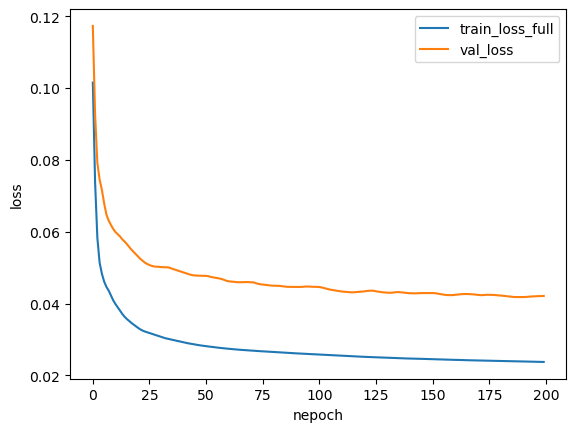

In [6]:
# train the rnn!
_,_,latv = rnn0.train(net,trainingData,trainingData,200,0.05,device,30, None, testData,testData)
# might not expect the model to generalize well, as the adjacency matrices might 
# differ between different neuron subpopulations

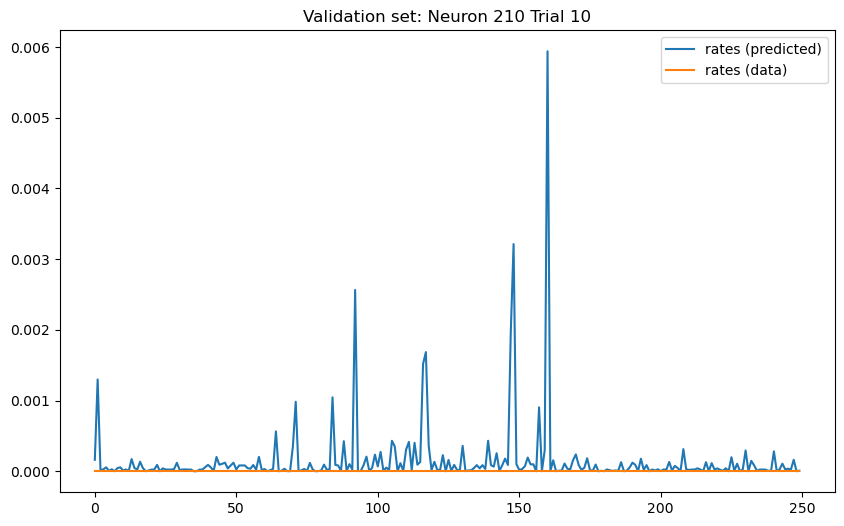

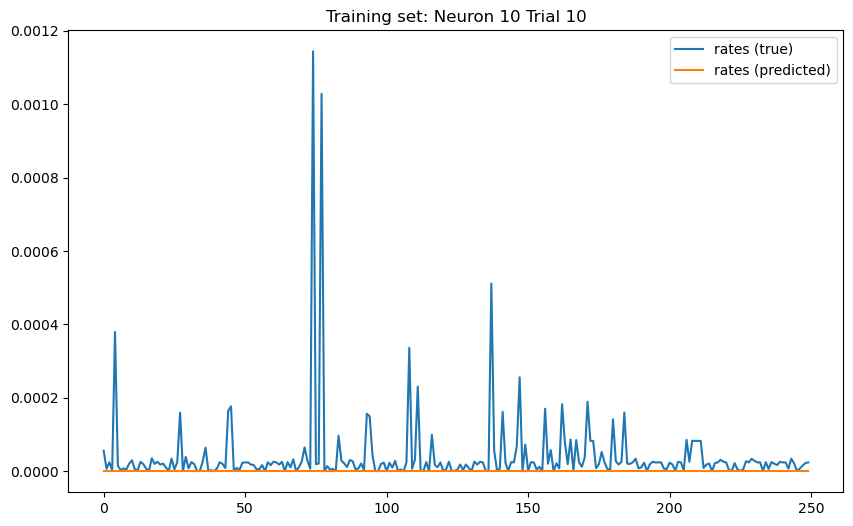

In [7]:
# visualize the performance of the rnn model
netinput=testData
prd,_=net(netinput)  
rpred = prd.detach().cpu().numpy()
nn = 10
ntrial = 10

# Plot for Test Data
plt.figure(figsize=(10, 6))
plt.plot(rpred[:,ntrial, nn], label='rates (predicted)')
plt.plot(testData[:, ntrial, nn], label='rates (data)')
plt.legend()
plt.title(f'Validation set: Neuron {nn+200} Trial {ntrial}')
plt.show()

# Plot for Training Data
netinput=trainingData
prd,_=net(netinput)  
rpred = prd.detach().cpu().numpy()
nn = 10
ntrial = 10
plt.figure(figsize=(10, 6))
#plt.plot(fake_spk_rates[:,ntrial, nn], label='rates (true)')
plt.plot(rpred[:,ntrial, nn], label='rates (predicted)')
plt.plot( trainingData[:, ntrial, nn], label='spikes')

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Training set: Neuron {nn} Trial {ntrial}')
plt.show()

In [8]:
## next: try the model with the real data